Since this code is run on a cloud server (kaggle) during development, the paths in the code need to be adjusted: TURTLE_DATASET_PATH should be changed to "../submit" (that is, it should be placed in the same directory as this code file), UNet_BEST_PATH should be changed to "../submit/pre_model/UNet_best_model (1).pth" and "../submit/pre_model/UNet_best_model.pth" UNet_best_model (1).pth is the path to the trained model, and UNet_best_model .pth is the new model after running the code

In [198]:
!pip install pycocotools
!pip install segmentation_models_pytorch

准备读取COCO文件

In [199]:
import numpy as np
import pandas as pd
import cv2 as cv 
import numpy as np
from pycocotools.coco import COCO
import os
import json
import seaborn as sns
import random
import matplotlib.pyplot as plt
import torch 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import albumentations as album 
from sklearn.model_selection import train_test_split
from typing import Callable
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

下载必要库

In [200]:
TURTLE_DATASET_PATH = "/kaggle/input/seaturtleid2022/turtles-data/data"
coco_dataset = COCO(f"{TURTLE_DATASET_PATH}/annotations.json")#load annotations

loading annotations into memory...
Done (t=5.71s)
creating index...
index created!


In [201]:
sp_image_files = ["images/t008/ShZANpaDrS.JPG", "images/t028/MbTOFSqlnF.JPG", "images/t028/RmjLIDpIVC.JPG"]
sp_image_ids = {}
for image in coco_dataset.loadImgs(coco_dataset.getImgIds()):
    if image['file_name'] in sp_image_files:
        sp_image_ids[image['file_name']] = image['id']
print(sp_image_ids)

{'images/t008/ShZANpaDrS.JPG': 184, 'images/t028/MbTOFSqlnF.JPG': 581, 'images/t028/RmjLIDpIVC.JPG': 586}


In [202]:
def display_images(figsize=(16,5), **images):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [203]:
train_ids, test_ids = train_test_split(coco_dataset.getImgIds()[2000:4000], test_size=0.2, random_state=None)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=None)
print(len(train_ids), len(val_ids), len(test_ids))#20%测试集，16%验证集，64%

1280 320 400


In [204]:
def render_image_with_b_box(id: int, coco: COCO, mask=False, cat_filter=None):
    coco_image = coco.loadImgs([id])[0]
    coco_image = cv.imread(f"{TURTLE_DATASET_PATH}/{coco_image['file_name']}")
    coco_image = cv.cvtColor(coco_image, cv.COLOR_BGR2RGB)
    cat_ids = coco.getCatIds()
    if cat_filter:
        cat_ids = coco.getCatIds(catNms=cat_filter)
    ann_ids = coco.getAnnIds(imgIds=id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    if mask:
        plt.imshow(coco_image)
        coco.showAnns(anns)
    else:
        for ann in anns:
            x, y, w, h = ann['bbox']
            cv.rectangle(coco_image, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 2)
        display_images(image=coco_image)

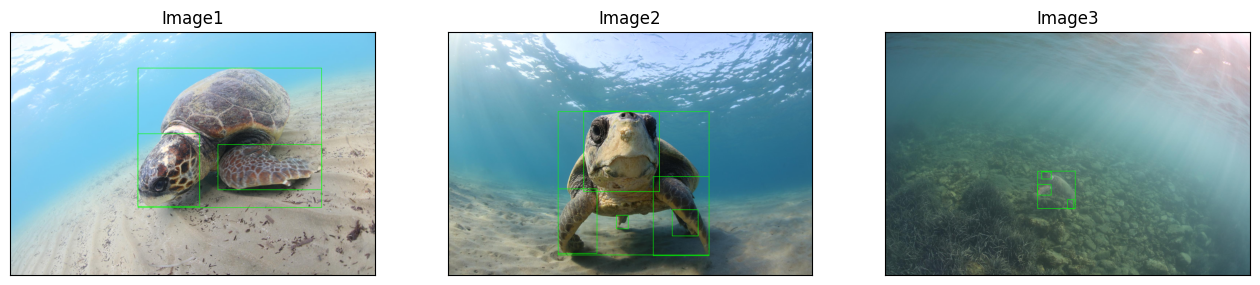

In [205]:
selected_images_for_display = []
for i in range(3):
    img_id = random.choice(train_ids)
    img_data = coco_dataset.loadImgs(img_id)[0]
    image = cv.imread(f"{TURTLE_DATASET_PATH}/{img_data['file_name']}")
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ann_ids = coco_dataset.getAnnIds(imgIds=img_data['id'])
    anns = coco_dataset.loadAnns(ann_ids)
    for ann in anns:
        x, y, w, h = ann['bbox']
        cv.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 2)
    selected_images_for_display.append(image)
display_images(image1=selected_images_for_display[0], image2=selected_images_for_display[1], image3=selected_images_for_display[2])

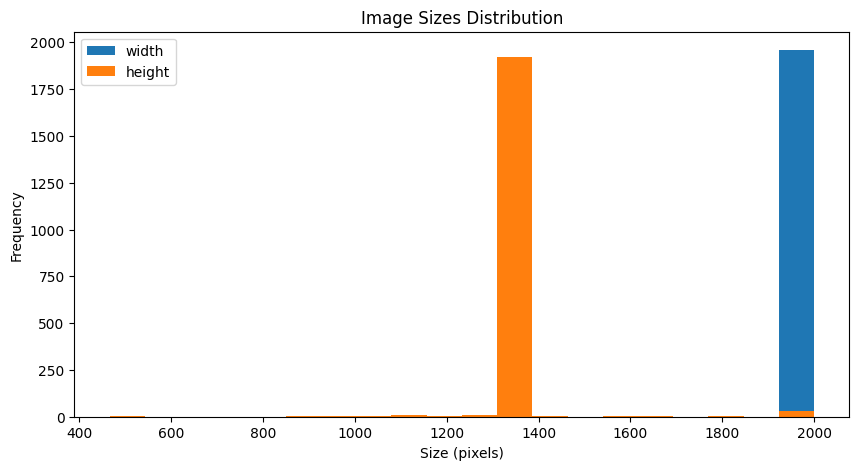

For the image with id: 3103 the size is: 1283 x 674


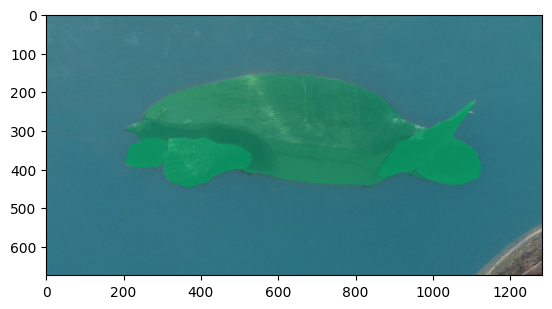

In [206]:
image_sizes = []
for img_id in train_ids + val_ids + test_ids:
    image = coco_dataset.loadImgs(img_id)[0]
    image_sizes.append((img_id, image['width'], image['height']))
image_dimensions_dataframe = pd.DataFrame(list(image_sizes), columns=['id', 'width', 'height'])
image_dimensions_dataframe.drop('id', axis=1).plot(kind='hist',bins=20, figsize=(10,5), title='Image Sizes Distribution')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.show()
#计算不规则尺寸图象之比例
(irregular_count := image_dimensions_dataframe[(image_dimensions_dataframe['height'] == 2000) & (image_dimensions_dataframe['width'] == 1333)].count() + \
image_dimensions_dataframe[(image_dimensions_dataframe['width'] == 2000) & (image_dimensions_dataframe['height'] == 1333)].count()) / \
image_dimensions_dataframe.count()
# 显示不规则尺寸的图像和标注
irrgular_size_images =  image_dimensions_dataframe[~((image_dimensions_dataframe['height'] == 2000) & (image_dimensions_dataframe['width'] == 1333) | (image_dimensions_dataframe['width'] == 2000) & (image_dimensions_dataframe['height'] == 1333))]
random_id, width, height = random.choice(irrgular_size_images.values)
render_image_with_b_box(random_id, coco_dataset, mask=True)
print("For the image with id:", random_id, "the size is:", width, "x", height)

Unique values in the mask1: [0 1]
Unique values in the mask2: [0 1]
Unique values in the mask3: [0 2]
Unique values in the mask: [0 1 2 3]


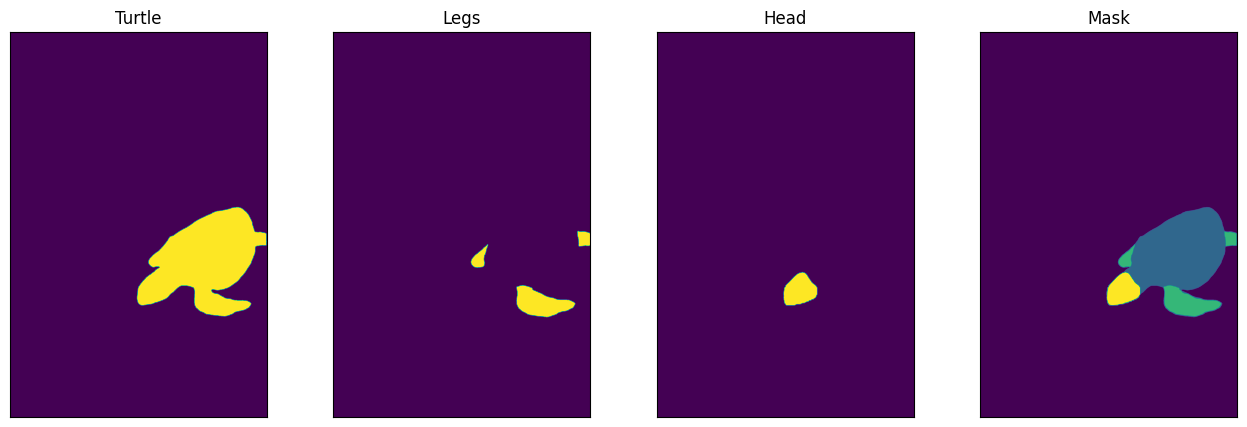

In [207]:
cat_ids = coco_dataset.getCatIds()
anns_ids = coco_dataset.getAnnIds(imgIds=random.randint(0, 8000), catIds=cat_ids, iscrowd=None)
anns = coco_dataset.loadAnns(anns_ids)
random_id = random.randint(0, 8000)
turtle_mask = coco_dataset.getAnnIds(imgIds=random_id, catIds=1, iscrowd=None)        # entire of the turtle
leg_mask = coco_dataset.getAnnIds(imgIds=random_id, catIds=2, iscrowd=None)        # legs of the turtle
head_mask = coco_dataset.getAnnIds(imgIds=random_id, catIds=3, iscrowd=None)        # Head of the turtle
turtle_mask = coco_dataset.loadAnns(turtle_mask)
leg_mask = coco_dataset.loadAnns(leg_mask)
head_mask = coco_dataset.loadAnns(head_mask)
mask1 = coco_dataset.annToMask(turtle_mask[0])
for i in range(1, len(turtle_mask)):
    mask1 += coco_dataset.annToMask(turtle_mask[i])
mask2 = np.zeros_like(mask1)
for i in range(len(leg_mask)):
    mask2 += coco_dataset.annToMask(leg_mask[i])
mask3 = np.zeros_like(mask2)
for i in range(len(head_mask)):
    mask3 += coco_dataset.annToMask(head_mask[i])
mask3[mask3 > 0] = 2
mask2[mask2 > 0] = 1
mask1[mask1 > 0] = 1
mask = mask1 + mask2 
mask[mask > 1] = 2
mask = mask + mask3
mask[mask > 2] = 3
print("Unique values in the mask1:", np.unique(mask1))
print("Unique values in the mask2:", np.unique(mask2))
print("Unique values in the mask3:", np.unique(mask3))
print("Unique values in the mask:", np.unique(mask))
display_images(turtle = mask1, legs = mask2, head = mask3, mask = mask)

Visualize some Training samples


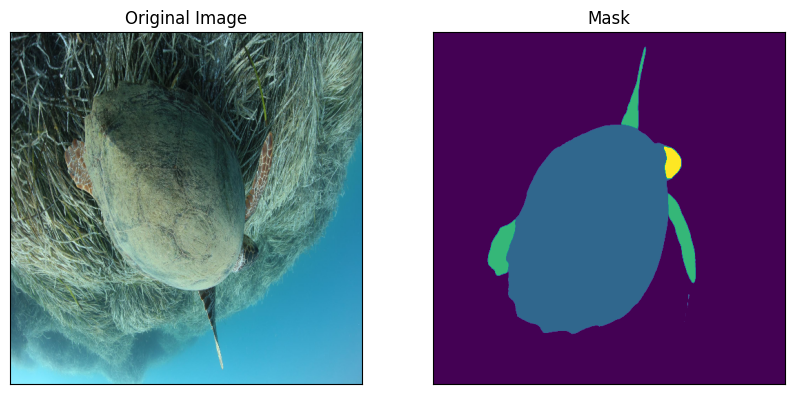

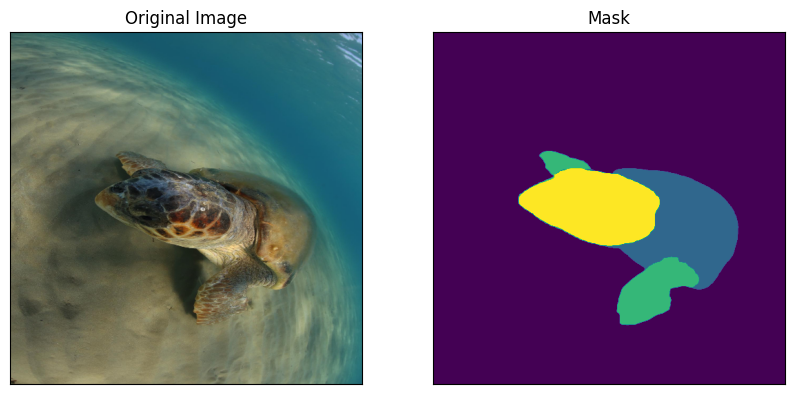

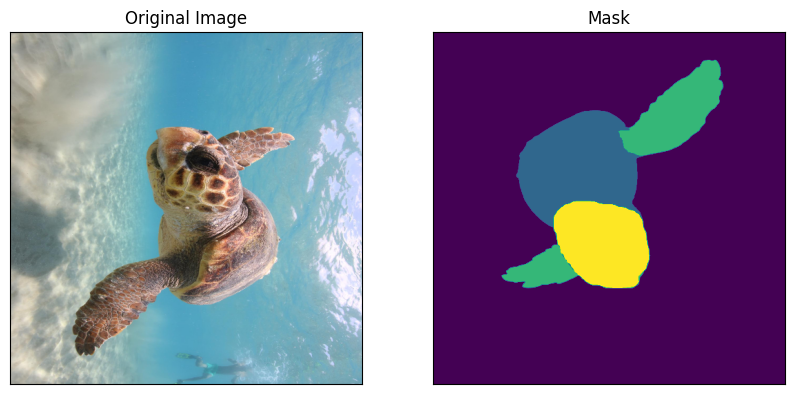

Visualize some Validation samples


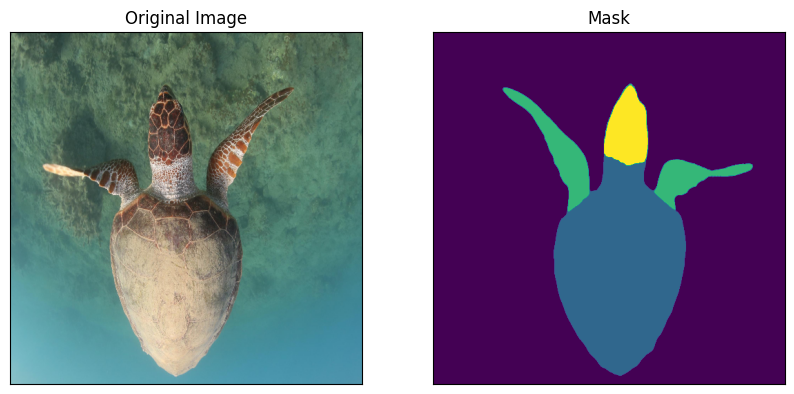

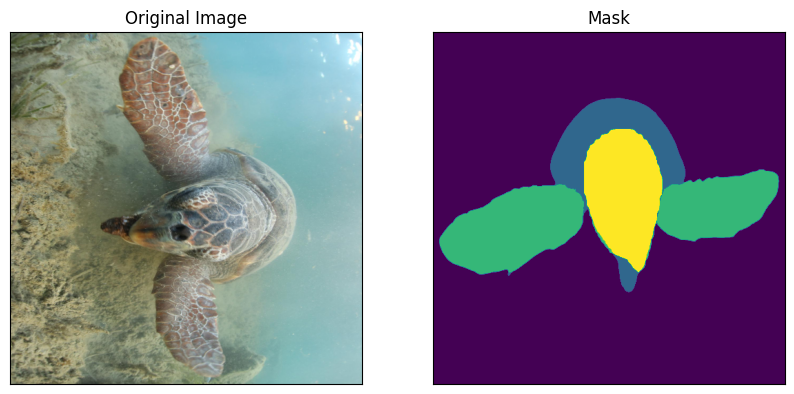

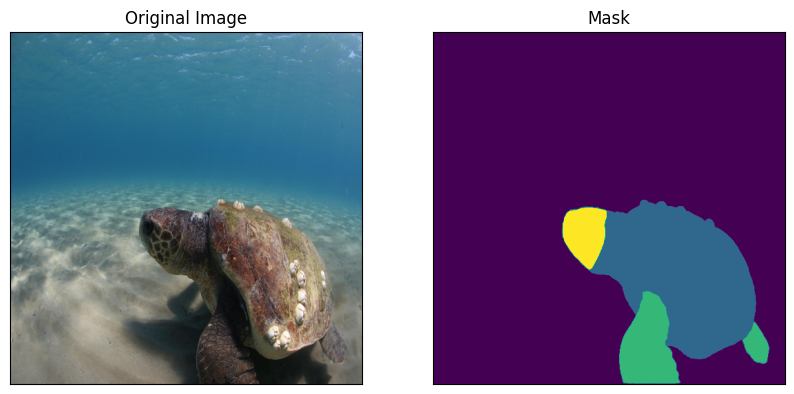

In [208]:
# Visualize some Training samples
print("Visualize some Training samples")
for _ in range(3):
    random_id = random.randint(0, len(train_dataset) - 1)
    image, target = train_dataset[random_id]
    display_images(figsize=(10, 5),original_image= image.permute(1, 2, 0).cpu().numpy().astype(np.int32), mask=target)
print("Visualize some Validation samples")
# Visualize some Validation samples
for _ in range(3):
    random_id = random.randint(0, len(val_dataset) - 1)
    image, target = val_dataset[random_id]
    display_images(figsize=(10, 5),original_image= image.permute(1, 2, 0).cpu().numpy().astype(np.int32), mask=target)

model

In [209]:
def transpose_to_tensor(x, *kwargs):
    return x.transpose(2,0,1).astype(np.float32)

def decorator_with_postprocessing(preprocessing_fn=None):
    def decorator(func):
        def wrapper(*args,**kwargs):
            _transform = []
            if preprocessing_fn:
                _transform.append(album.Lambda(image=preprocessing_fn))
            _transform.extend(func(*args,**kwargs))
            _transform.append(ToTensorV2())
            return album.Compose(_transform)
        return wrapper
    return decorator

@decorator_with_postprocessing(None)
def generate_transformation_list(*args,**kwargs): 
    _transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomRotate90(p=0.5),
        album.OneOf([
            album.GaussNoise(),
            album.MotionBlur(p=0.2),
            album.MedianBlur(blur_limit=3, p=0.1),
            album.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    ]
    return _transform

def build_augmentation_pipeline():
    transform = [
         album.HorizontalFlip(p=0.5),
         album.VerticalFlip(p=0.5),
         album.RandomRotate90(p=0.5),
    ]
    return album.Compose(transform)


def setup_validation_transforms():
    transform = [
         album.HorizontalFlip(p=0.5),
         album.VerticalFlip(p=0.5),
         album.RandomRotate90(p=0.5),
    ]
    return album.Compose(transform)

In [210]:
class TurtleImageDataset(Dataset):
    def __init__(self, coco: COCO, image_ids:list, 
                 augmentation: Callable[[np.ndarray, dict], dict] | None = None, 
                 preprocessing: Callable[[np.ndarray, dict], dict] | None = None):
        self.coco = coco
        self.image_ids = image_ids
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.catIds = coco.getCatIds()
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = self.coco.loadImgs([image_id])[0]
        image = cv.imread(f"{TURTLE_DATASET_PATH}/{image['file_name']}")
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        
        turtle_mask = coco_dataset.getAnnIds(imgIds=image_id, catIds=1, iscrowd=None)  
        leg_mask = coco_dataset.getAnnIds(imgIds=image_id, catIds=2, iscrowd=None)  
        head_mask = coco_dataset.getAnnIds(imgIds=image_id, catIds=3, iscrowd=None)  
        turtle_mask = coco_dataset.loadAnns(turtle_mask)
        leg_mask = coco_dataset.loadAnns(leg_mask)
        head_mask = coco_dataset.loadAnns(head_mask)
        mask1 = np.zeros((image.shape[0], image.shape[1]))
        for i in range(len(turtle_mask)):
            mask1 += coco_dataset.annToMask(turtle_mask[i])
        mask2 = np.zeros_like(mask1)
        for i in range(len(leg_mask)):
            mask2 += coco_dataset.annToMask(leg_mask[i])
        mask3 = np.zeros_like(mask2)
        for i in range(len(head_mask)):
            mask3 += coco_dataset.annToMask(head_mask[i])
        mask3[mask3 > 0] = 2
        mask2[mask2 > 0] = 1
        mask1[mask1 > 0] = 1
        mask = mask1 + mask2 
        mask[mask > 1] = 2
        mask = mask + mask3
        mask[mask > 2] = 3
        image = cv.resize(image, (512, 512))
        mask = cv.resize(mask, (512, 512))
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        if self.augmentation:
            transformed = self.augmentation(image=image, mask=mask)
            image = transformed["image"]
            targets = transformed["mask"]

        if self.preprocessing:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            targets = transformed["mask"]
        return image, targets
train_dataset = TurtleImageDataset(coco_dataset, train_ids, 
                         augmentation=build_augmentation_pipeline(), 
                         preprocessing=generate_transformation_list())
val_dataset = TurtleImageDataset(coco_dataset, val_ids,
                            augmentation=setup_validation_transforms(), 
                            preprocessing=generate_transformation_list())

In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        #CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, input_channels, num_classes, bilinear=False):
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(input_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, num_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [212]:
UNet_BEST_PATH = "/kaggle/input/pre_model/pytorch/default/1/UNet_best_model (1).pth"
def load_model(path, model=None):
    if os.path.exists(path):
        loaded_model = torch.load(path)
        print(f"Loaded model from a previous commit.")
        return loaded_model
    return model
unet = load_model(UNet_BEST_PATH, UNet(num_classes=4, input_channels=3))

Loaded model from a previous commit.


/tmp/ipykernel_30/899965012.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(path)


Traning

In [ ]:
def training(model, loss, metrics, optimizer, train_loader, val_loader, device, n_epoch=10, best=True, save_step = 10, default_name="unknown_name", early_stop=5):
    train_epoch = smp_utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=device,
        verbose=True,
    )
    val_epoch = smp_utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=True,
    )
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    not_best=0
    try:
        model_name = model.__class__.__name__
    except Exception as e:
        model_name = default_name
    for i in range(0, n_epoch):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = val_epoch.run(val_loader)
#         print(valid_logs)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['MultiClassIoU']:
            best_iou_score = valid_logs['MultiClassIoU']
            torch.save(model, f'./{model_name}_best_model.pth')
            print('Model saved!')
            not_best = 0
        else:
            if not_best > early_stop:
                torch.save(model, f'./{model_name}_epoch_{i}.pth')
                break
            not_best += 1
        if i % save_step == 0:
            torch.save(model, f'./{model_name}_epoch_{i}.pth')
    if best:
        if os.path.exists(f'./{model_name}_best_model.pth'):
            model = torch.load(f'./{model_name}_best_model.pth')
    pd.DataFrame(train_logs_list).to_csv(f'./{model_name}_train_logs.csv', index=False)
    pd.DataFrame(valid_logs_list).to_csv(f'./{model_name}_valid_logs.csv', index=False)
    return model, train_logs_list, valid_logs_list
def plot_logs(train_logs_list, valid_logs_list):
    train_logs_df = pd.DataFrame(train_logs_list)
    valid_logs_df = pd.DataFrame(valid_logs_list)
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.lineplot(data=train_logs_df[['MultiClassCombinedLoss', 'MultiClassIoU']], ax=axes[0])
    axes[0].set_title('Training Metrics')
    sns.lineplot(data=valid_logs_df[['MultiClassCombinedLoss', 'MultiClassIoU']], ax=axes[1])
    axes[1].set_title('Validation Metrics')
    plt.show()

In [214]:
import torch
import torch.nn as nn
class MultiClassIoU(nn.Module):
    def __init__(self, num_classes, ignore_index=None, eps=1e-6):
        super(MultiClassIoU, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.eps = eps

    @property
    def __name__(self):
        return "MultiClassIoU"
    
    def __repr__(self):
        return f"MultiClassIoU(num_classes={self.num_classes})"
    
    def __str__(self):
        return f"MultiClassIoU(num_classes={self.num_classes})"
    
    def forward(self, predictions, targets):
        device = predictions.device
        if len(predictions.shape) == 4:  # (B, C, H, W)
            predictions = torch.argmax(predictions, dim=1)  # Convert to (B, H, W)
        
        predictions = predictions.to(device)
        targets = targets.to(device)
        
        iou_per_class = []
        
        for class_idx in range(self.num_classes):
            if class_idx == self.ignore_index:
                continue
            pred_mask = (predictions == class_idx).float()
            target_mask = (targets == class_idx).float()
            intersection = (pred_mask * target_mask).sum().to(device)
            union = (pred_mask + target_mask).gt(0).float().sum().to(device)
            iou = torch.where(
                union > 0,
                intersection / (union + self.eps),
                torch.tensor(0.0, device=device)
            )
            
            iou_per_class.append(iou)
        
        if len(iou_per_class) > 0:
            iou_per_class = torch.stack(iou_per_class)
            mean_iou = iou_per_class.mean()
        else:
            mean_iou = torch.tensor(1e-6, device=device)
            
        return mean_iou

    def per_class_iou(self, predictions, targets):
        device = predictions.device
        if len(predictions.shape) == 4:
            predictions = torch.argmax(predictions, dim=1)
            
        predictions = predictions.to(device)
        targets = targets.to(device)
        
        results = {}
        
        for class_idx in range(self.num_classes):
            if class_idx == self.ignore_index:
                continue
                
            pred_mask = (predictions == class_idx).float()
            target_mask = (targets == class_idx).float()
            
            intersection = (pred_mask * target_mask).sum().to(device)
            union = (pred_mask + target_mask).gt(0).float().sum().to(device)
            
            iou = torch.where(
                union > 0,
                intersection / (union + self.eps),
                torch.tensor(0.0, device=device)
            )
            
            results[f'class_{class_idx}_iou'] = iou.item()
        return results
MultiClassIoU(4).__name__

'MultiClassIoU'

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassCombinedLoss(nn.Module):
    def __init__(self, 
                 num_classes,
                 alpha=0.5,    # Weight for Dice Loss
                 beta=0.3,     # Weight for Focal Loss
                 gamma=0.2,    # Weight for Cross Entropy
                 focal_gamma=2, # Focal Loss focusing parameter
                 epsilon=1e-6,  # Small constant to avoid division by zero
                 class_weights=None):
        
        super(MultiClassCombinedLoss, self).__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.focal_gamma = focal_gamma
        self.epsilon = epsilon
        self.name = "MultiClassIoU"
        
        if class_weights is None:
            self.class_weights = torch.ones(num_classes)
        else:
            self.class_weights = class_weights
            
    def dice_loss(self, inputs, targets):
        batch_size = inputs.size(0)
        inputs = F.softmax(inputs, dim=1)
        inputs = inputs.reshape(batch_size, self.num_classes, -1)
        targets = targets.reshape(batch_size, -1)
        dice_loss = 0.0
        for class_idx in range(self.num_classes):
            inputs_class = inputs[:, class_idx, :]  # (B, H*W)
            targets_class = (targets == class_idx).float()  # (B, H*W)
            intersection = (inputs_class * targets_class).sum(dim=1)  # (B,)
            union = inputs_class.sum(dim=1) + targets_class.sum(dim=1)  # (B,)
            class_dice = (2. * intersection + self.epsilon) / (union + self.epsilon)  # (B,)
            class_dice = class_dice.mean()
            dice_loss += (1 - class_dice) * self.class_weights[class_idx].to(inputs.device)
        return dice_loss / self.num_classes


    
    def focal_loss(self, inputs, targets):
        eps = 1e-7
        inputs = inputs.reshape(-1, self.num_classes)
        targets = targets.reshape(-1).long()  # Ensure targets are long type
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1.)
        probs = torch.clamp(probs, eps, 1. - eps)
        ce = -(targets_one_hot * torch.log(probs)).sum(dim=1)
        pt = (targets_one_hot * probs).sum(dim=1)
        focal_term = (1 - pt) ** self.focal_gamma
        focal_loss = focal_term * ce
        if self.class_weights is not None:
            class_weights = self.class_weights.to(inputs.device)
            weight_term = (targets_one_hot * class_weights.unsqueeze(0)).sum(dim=1)
            focal_loss = focal_loss * weight_term
        return focal_loss.mean()

    def cross_entropy_loss(self, inputs, targets):
        inputs = inputs.reshape(-1, self.num_classes)
        targets = targets.reshape(-1)
        log_probs = F.log_softmax(inputs, dim=1)
        targets_one_hot = torch.zeros_like(inputs)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        weights = self.class_weights.to(inputs.device)
        weighted_targets = targets_one_hot * weights.unsqueeze(0)
        ce_loss = -(weighted_targets * log_probs).sum(dim=1).mean()
        return ce_loss
    
    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.long()
        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)
        ce = self.cross_entropy_loss(inputs, targets)
        combined_loss = (self.alpha * dice + 
                        self.beta * focal + 
                        self.gamma * ce)
        return combined_loss
    
    @property
    def __name__(self):
        return "MultiClassCombinedLoss"
    
    def __repr__(self):
        return f"MultiClassCombinedLoss(num_classes={self.num_classes})"
    
    def __str__(self):
        return f"MultiClassCombinedLoss(num_classes={self.num_classes})"

training model

In [216]:
TRAINING = True

In [217]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [218]:
import segmentation_models_pytorch.utils as smp_utils 
loss = MultiClassCombinedLoss(4)
metrics = [
    MultiClassIoU(4),
]
optimizer = torch.optim.Adam([
    dict(params=unet.parameters(), lr=0.01),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [219]:
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0


Epoch: 0
valid: 100%|██████████| 320/320 [00:17<00:00, 18.51it/s, MultiClassCombinedLoss - 0.5363, MultiClassIoU - 0.2232]
Model saved!

Epoch: 1
valid: 100%|██████████| 320/320 [00:17<00:00, 18.14it/s, MultiClassCombinedLoss - 0.5138, MultiClassIoU - 0.266] 
Model saved!

Epoch: 2
valid: 100%|██████████| 320/320 [00:17<00:00, 17.91it/s, MultiClassCombinedLoss - 0.5091, MultiClassIoU - 0.2669]
Model saved!

Epoch: 3
valid: 100%|██████████| 320/320 [00:17<00:00, 17.89it/s, MultiClassCombinedLoss - 0.5034, MultiClassIoU - 0.2802]
Model saved!

Epoch: 4
valid: 100%|██████████| 320/320 [00:18<00:00, 17.71it/s, MultiClassCombinedLoss - 0.5006, MultiClassIoU - 0.2846]
Model saved!

Epoch: 5
valid: 100%|██████████| 320/320 [00:18<00:00, 17.76it/s, MultiClassCombinedLoss - 0.5261, MultiClassIoU - 0.2489]

Epoch: 6
valid: 100%|██████████| 320/320 [00:17<00:00, 17.88it/s, MultiClassCombinedLoss - 0.5119, MultiClassIoU - 0.2671]

Epoch: 7
valid: 100%|██████████| 320/320 [00:18<00:00, 17.73it/s, 

/tmp/ipykernel_30/1443212352.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'./{model_name}_best_model.pth')
/opt/conda/lib/python3.10/site-package

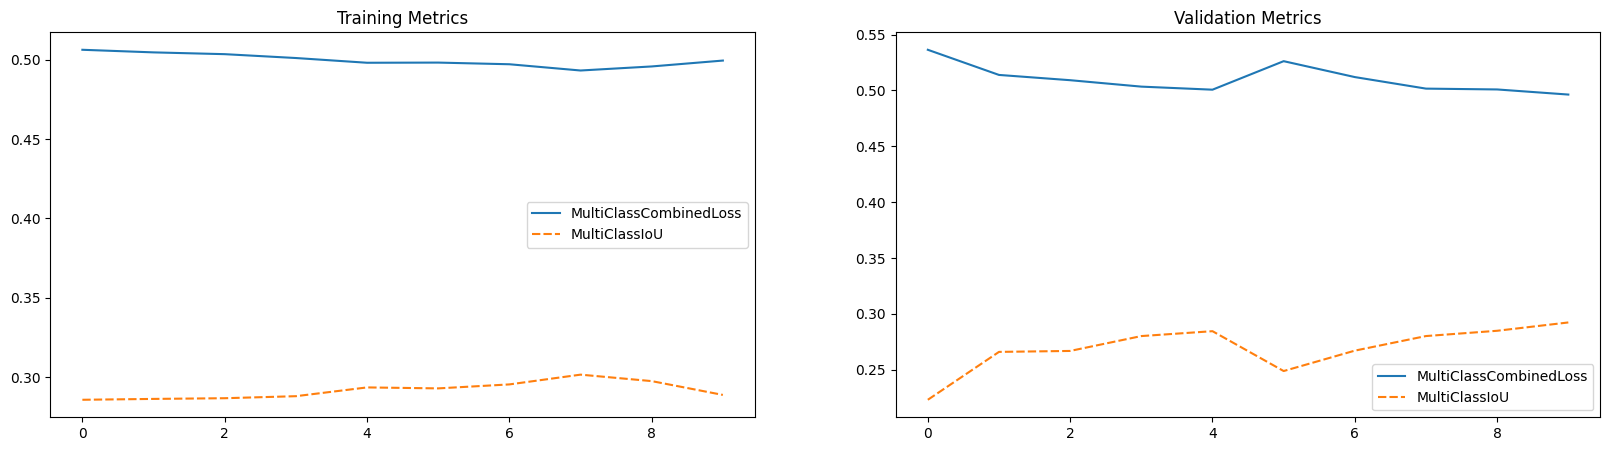

In [220]:
if TRAINING:
     unet, train_logs_list, valid_logs_list = training(unet, loss, metrics, optimizer, train_loader, val_loader, device)
     plot_logs(train_logs_list, valid_logs_list)

In [221]:
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()

7602

Test and Visualization

In [222]:
def testing(model, test_loader, loss, metrics, device, display_num=10):
    test_epoch = smp_utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=True,
    )
    test_logs = test_epoch.run(test_loader)
    print('Test IoU score:', test_logs['MultiClassIoU'])
    print('Test Dice loss:', test_logs['MultiClassCombinedLoss'])
    #存储所有图像的每类IoU，以计算平均值
    all_class_ious = {f'class_{i}_iou': [] for i in range(metrics[0].num_classes)}
    for _ in range(display_num):
        random_id=np.random.randint(0, len(test_dataset))
        image, mask = test_dataset[random_id]
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0).to(device)
        image = image.to(device)
        with torch.no_grad():
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)
            # 为每个类别计算 IoU
            per_class_results = metrics[0].per_class_iou(pred_mask, mask)
            print(f'Per-class IoU for image {random_id}:', per_class_results)
            #储存每个类别的IoU
            for key, value in per_class_results.items():
                all_class_ious[key].append(value)
            #打印
            image_np = image[0].permute(1, 2, 0).cpu().numpy().astype(np.int32)
            mask_np = mask.squeeze(0).cpu().numpy()
            pred_mask_np = pred_mask.squeeze(0).cpu().numpy()
            
            print("Image id:", random_id)
            display_images(image=image_np, true_ground=mask_np, pred_mask=pred_mask_np)
    #计算并打印每个类别的平均IoU
    avg_class_ious = {k: np.mean(v) for k, v in all_class_ious.items()}
    print("mIoU for all classes:", avg_class_ious)
    return test_logs

In [223]:
import os
UNet_BEST_PATH = "/kaggle/working/UNet_best_model.pth"
def load_model(path):
    if os.path.exists(path):
        model = torch.load(path)
        print(f"Loaded {model.__class__.__name__} model from a previous commit.")
        return model
    return None
unet = load_model(UNet_BEST_PATH)

Loaded UNet model from a previous commit.


/tmp/ipykernel_30/252305114.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


In [224]:
test_dataset = TurtleImageDataset(coco_dataset, test_ids,generate_transformation_list())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [225]:
print(unet)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

valid: 100%|██████████| 400/400 [00:23<00:00, 17.11it/s, MultiClassCombinedLoss - 0.4285, MultiClassIoU - 0.4058]
Test IoU score: 0.40578009922057395
Test Dice loss: 0.4285006983950735
Per-class IoU for image 338: {'class_0_iou': 0.9673701524734497, 'class_1_iou': 0.7104310989379883, 'class_2_iou': 0.4435807168483734, 'class_3_iou': 0.2932509481906891}
Image id: 338


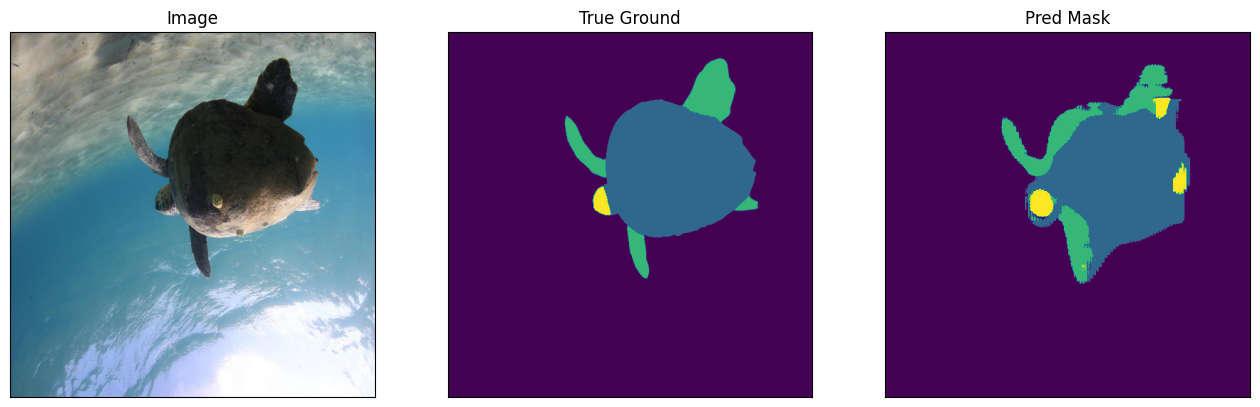

Per-class IoU for image 30: {'class_0_iou': 0.880778431892395, 'class_1_iou': 0.19608174264431, 'class_2_iou': 0.16569234430789948, 'class_3_iou': 0.24816255271434784}
Image id: 30


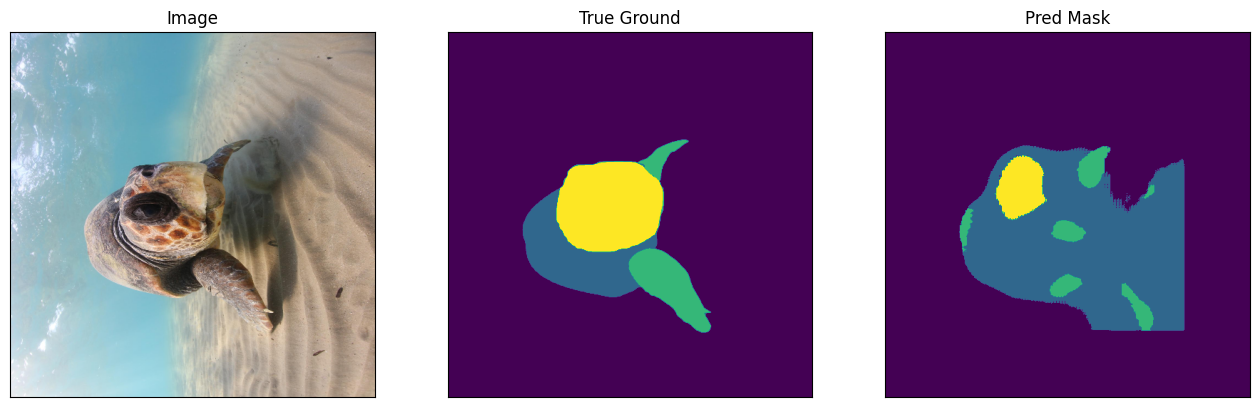

Per-class IoU for image 256: {'class_0_iou': 0.7237257957458496, 'class_1_iou': 0.1699904501438141, 'class_2_iou': 0.0012270380975678563, 'class_3_iou': 0.0002894714998546988}
Image id: 256


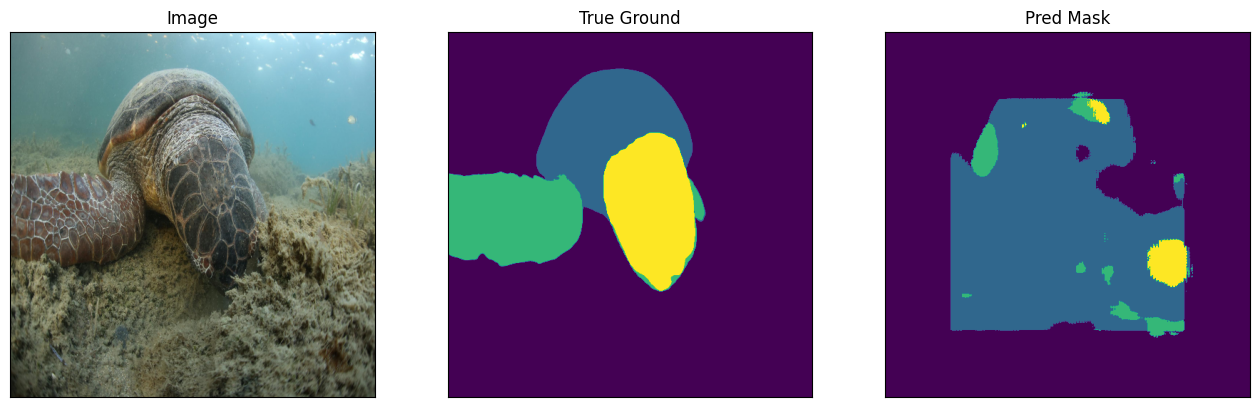

Per-class IoU for image 381: {'class_0_iou': 0.9193753600120544, 'class_1_iou': 0.3484449088573456, 'class_2_iou': 0.10923881828784943, 'class_3_iou': 0.09813838452100754}
Image id: 381


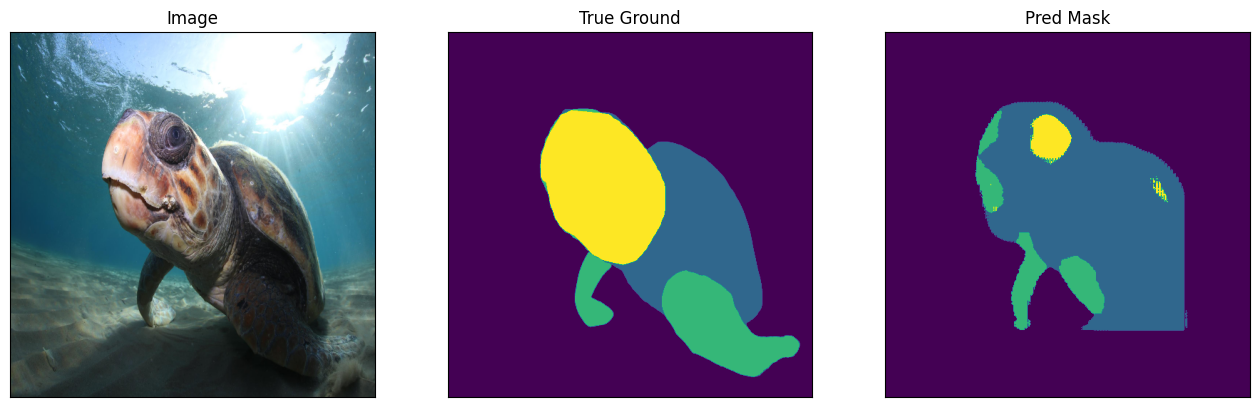

Per-class IoU for image 271: {'class_0_iou': 0.5933687090873718, 'class_1_iou': 0.00476622162386775, 'class_2_iou': 0.0, 'class_3_iou': 0.0}
Image id: 271


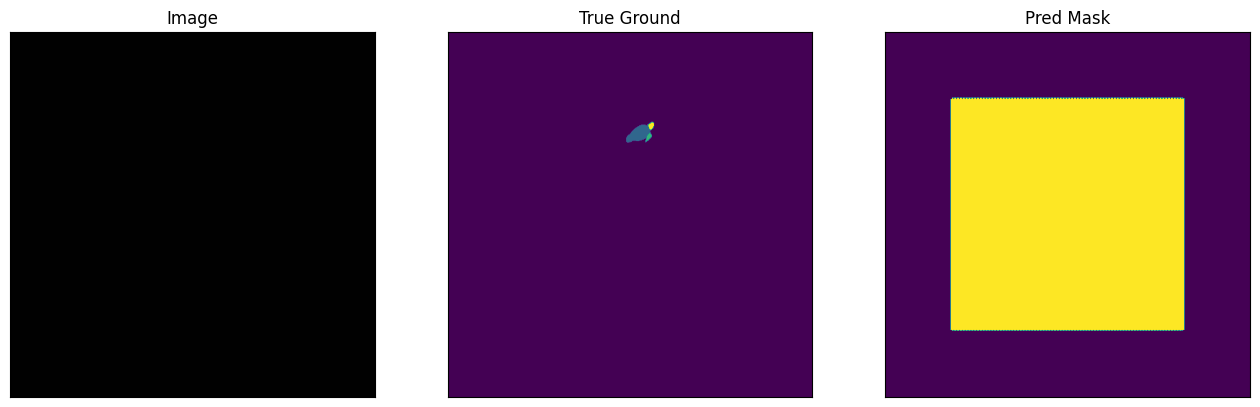

Per-class IoU for image 138: {'class_0_iou': 0.7790977358818054, 'class_1_iou': 0.15558940172195435, 'class_2_iou': 0.025317711755633354, 'class_3_iou': 0.047138046473264694}
Image id: 138


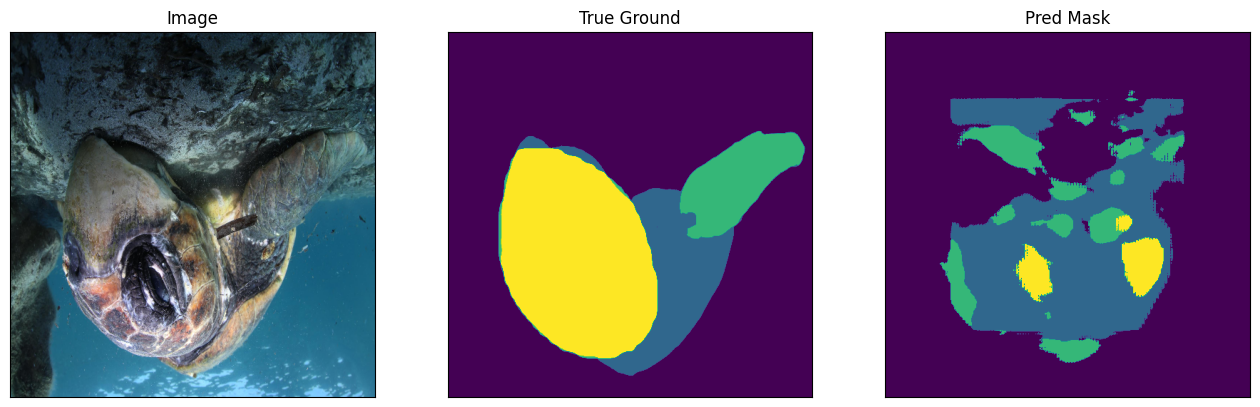

Per-class IoU for image 176: {'class_0_iou': 0.9604728817939758, 'class_1_iou': 0.6679590940475464, 'class_2_iou': 0.35558658838272095, 'class_3_iou': 0.6961326003074646}
Image id: 176


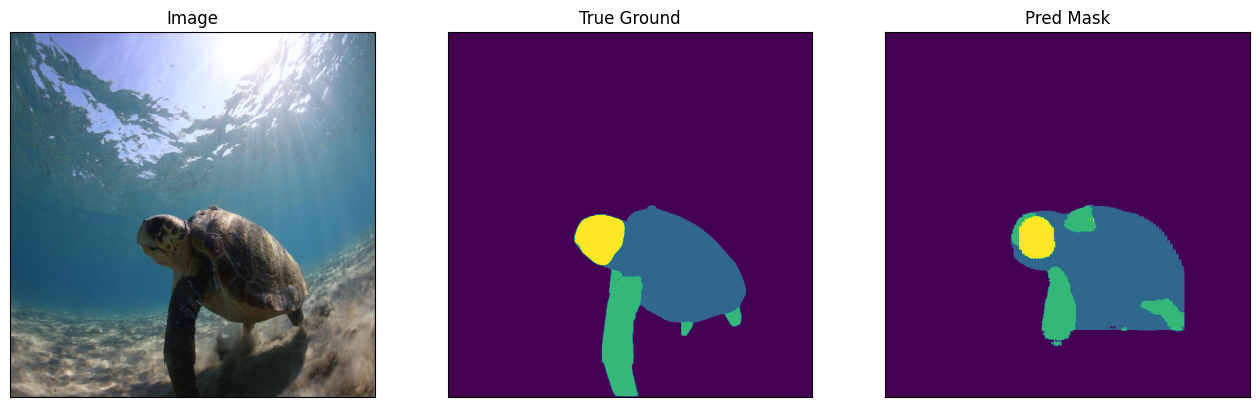

Per-class IoU for image 94: {'class_0_iou': 0.8515064120292664, 'class_1_iou': 0.5309908390045166, 'class_2_iou': 0.049962036311626434, 'class_3_iou': 0.26169517636299133}
Image id: 94


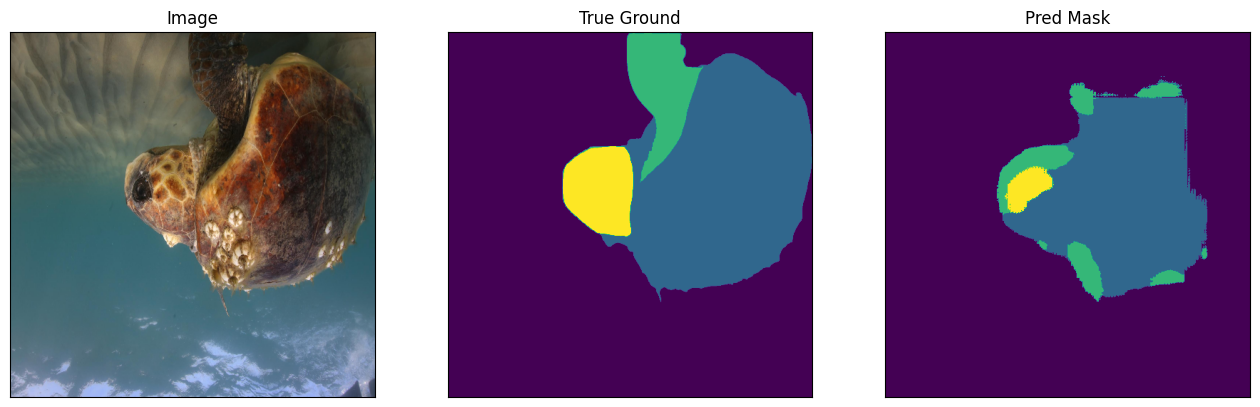

Per-class IoU for image 130: {'class_0_iou': 0.8541014790534973, 'class_1_iou': 0.5907729864120483, 'class_2_iou': 0.13954146206378937, 'class_3_iou': 0.7906301617622375}
Image id: 130


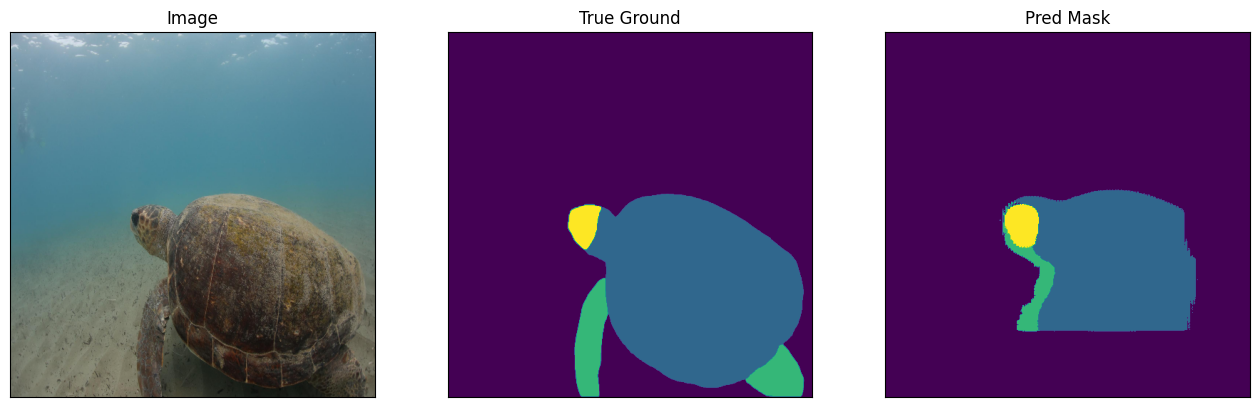

Per-class IoU for image 79: {'class_0_iou': 0.9370110034942627, 'class_1_iou': 0.41619470715522766, 'class_2_iou': 0.26983895897865295, 'class_3_iou': 0.5773133039474487}
Image id: 79


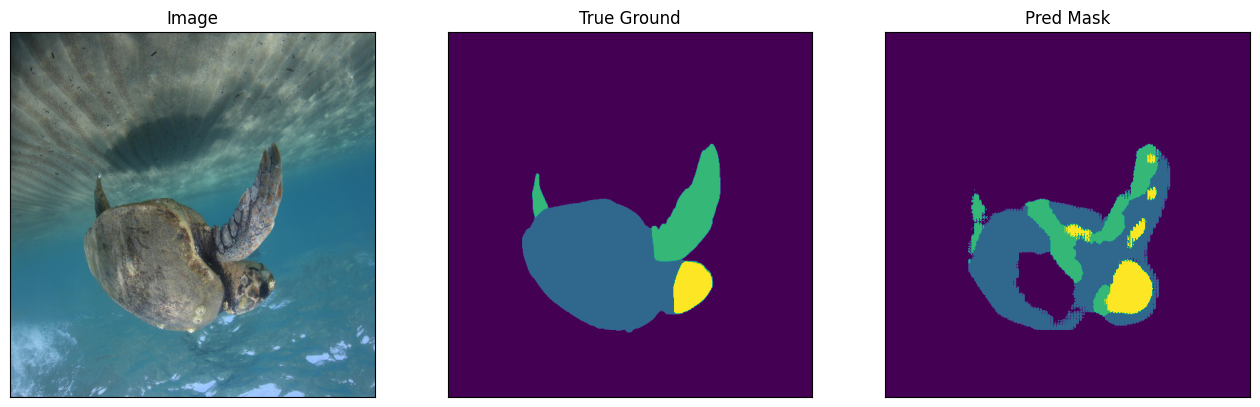

mIoU for all classes: {'class_0_iou': 0.8466807961463928, 'class_1_iou': 0.3791221450548619, 'class_2_iou': 0.15599856750341132, 'class_3_iou': 0.30127506457793063}


{'MultiClassCombinedLoss': 0.4285006983950735,
 'MultiClassIoU': 0.40578009922057395}

In [226]:
testing(unet, test_loader, loss, metrics, device)

class_0_iou：background；
class_1_iou：turtle's body；
class_2_iou：turtle's legs；
class_3_iou：turtle's head